In [1]:
from datasets.kitti_dataset import KittiDataset

In [2]:
kitti_dataset_path = '/home/cedric/GuidedContrast/dataset/semantic_kitti/'
sequence = '00'
sam_labels_path = None

dataset = KittiDataset(kitti_dataset_path, 
                       sequence, 
                       sam_labels_path)

labels_folder = '/home/cedric/segcontrast/Datasets/SemanticKITTI/dataset/sequences/00/labels/'

In [3]:
from segmentation.voxel_clustering_segmentation import VoxelClusterSegmentation
from segmentation.dbscan_patchwork_segmentation import DbscanPatchworkSegmentation
from segmentation.dbscan_segmentation import DbscanSegmentation

voxel_segmentation = VoxelClusterSegmentation(dataset)
patch_dbscan_segmentation = DbscanPatchworkSegmentation(dataset)
plane_dbscan_segmentation = DbscanSegmentation(dataset)
names = ['Patchwork++,Voxel Cluster','Patchwork++,DBScan','Plane Fitting,DBScan']
geometrical_segmenters = [voxel_segmentation,patch_dbscan_segmentation,plane_dbscan_segmentation]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
PatchWorkpp::PatchWorkpp() - INITIALIZATION COMPLETE
PatchWorkpp::PatchWorkpp() - INITIALIZATION COMPLETE


### Run baselines

In [4]:
import os
import numpy as np

from tqdm import tqdm

visual_labels = []
geometrical_labels = {}
for name in names : 
    geometrical_labels[name] = []
gt_labels = []

cnt = 0 
for i in tqdm(range(0, len(dataset.poses), 50)):
    for j,name in enumerate(names):
        geometrical_labels[name].append(geometrical_segmenters[j].segment_instances(i))
    labels_file_path = os.path.join(labels_folder, '{}.label'.format(str(i).zfill(6)))
    gt_labels.append(np.fromfile(labels_file_path, dtype=np.uint32))
    #if cnt == 10 : 
    #    break
    
    cnt += 1


100%|██████████| 91/91 [07:47<00:00,  5.14s/it]


### Visualize baselines

In [5]:
import random

def generate_random_colors(N):
    colors = []
    for _ in range(N):
        colors.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])

    return colors

random_colors = generate_random_colors(500)

In [6]:
import numpy as np
import open3d as o3d

def color_points_by_labels(points, labels):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    colors = []

    for i in range(labels.shape[0]):
        colors.append(random_colors[int(labels[i]) + 1])

    pcd.colors = o3d.utility.Vector3dVector(np.vstack(colors) / 255)

    return pcd

In [7]:
index = 0
points = dataset.get_point_cloud(index)
o3d.visualization.draw_geometries([color_points_by_labels(points, geometrical_labels[names[0]][index])])

### Evaluation

In [8]:
import instanseg
from instanseg.metrics import precision, recall, fScore

instanseg.metrics.constants.IOU_THRESHOLD_FULL = 0.5
tp_condition = 'iou'

In [9]:
import pandas as pd

results_dict = []

for i in tqdm(range(len(geometrical_labels[names[0]]))):

    for name in names: 
        res = {
            'index': i,
            'method': name,
            'precision': precision(geometrical_labels[name][i], gt_labels[i], tp_condition),
            'recall': recall(geometrical_labels[name][i], gt_labels[i], tp_condition),
            'fscore': fScore(geometrical_labels[name][i], gt_labels[i], tp_condition)
        }
        
        results_dict.append(res)
    


100%|██████████| 91/91 [05:19<00:00,  3.52s/it]


In [10]:
df = pd.DataFrame.from_records(results_dict, index=np.arange(len(results_dict)))

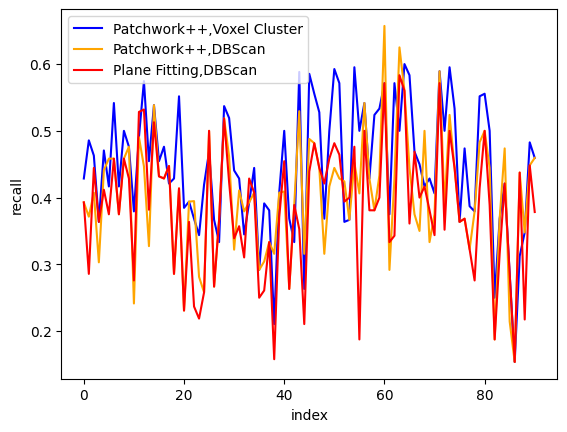

In [19]:
import matplotlib.pyplot as plt

plt.xlabel('index')  # Optional: Add X-axis label
metric = 'recall'
plt.ylabel(metric)  # Optional: Add Y-axis label
colors = ['blue','orange','red']
for i,name in enumerate(names) : 
        df_cur = df[df['method'] == name]
        plt.plot(df_cur['index'].values, df_cur[metric].values,color=colors[i],label=name)

plt.legend()

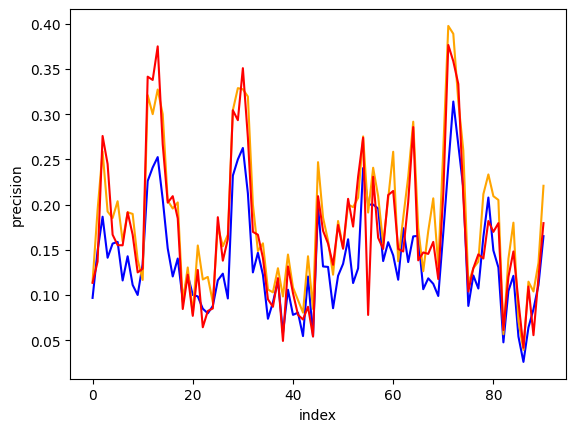

In [24]:

plt.xlabel('index')  # Optional: Add X-axis label
metric = 'precision'
plt.ylabel(metric)  # Optional: Add Y-axis label
colors = ['blue','orange','red']
for i,name in enumerate(names) : 
        df_cur = df[df['method'] == name]
        plt.plot(df_cur['index'].values, df_cur[metric].values,color=colors[i],label=name)


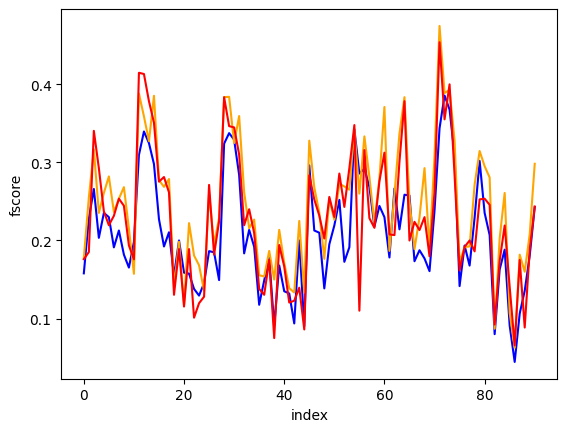

In [25]:
plt.xlabel('index')  # Optional: Add X-axis label
metric = 'fscore'
plt.ylabel(metric)  # Optional: Add Y-axis label
colors = ['blue','orange','red']
for i,name in enumerate(names) : 
        df_cur = df[df['method'] == name]
        plt.plot(df_cur['index'].values, df_cur[metric].values,color=colors[i],label=name)


### Table for comparing averaged metrics over the dataset

In [26]:

from prettytable import PrettyTable
table = PrettyTable()
table.field_names =  ['Metric'] +  names

metrics = ['recall','precision','fscore']
for i in range(3): 
        row = [metrics[i]]
        for j,name in enumerate(names): 
                cur_df = df[df['method'] == name]
                row.append(round(cur_df[metrics[i]].mean(),3))
        table.add_row(row)

print(table)

+-----------+---------------------------+--------------------+----------------------+
|   Metric  | Patchwork++,Voxel Cluster | Patchwork++,DBScan | Plane Fitting,DBScan |
+-----------+---------------------------+--------------------+----------------------+
|   recall  |           0.447           |       0.403        |        0.384         |
| precision |           0.139           |       0.184        |        0.169         |
|   fscore  |           0.209           |       0.247        |        0.229         |
+-----------+---------------------------+--------------------+----------------------+
